### Loading the data

In [59]:
import json
import pandas as pd
import numpy as np



# Loading data


with open('../StatsBomb/Data/FAWSL_22_23.json') as data_file:    
    data = json.load(data_file)  

fawsl = pd.json_normalize(data).sort_values('match_date')



events = pd.DataFrame()
lineups = pd.DataFrame()
lineups_positions = pd.DataFrame()
lineups_events = pd.DataFrame()


matches = {'Arsenal' : 3852832,
           'AstonVilla' : 3856030,
           'Brighton' : 3855980,
           'LeicesterCity' : 3855947,
           'Liverpool' : 3855961,
           'Tottenham' : 3856040}


for i in matches:
    
    with open('../StatsBomb/Data/ManCity_' + i + '_events.json') as data_file:    
        data = json.load(data_file)
    normalized_data = pd.json_normalize(data).sort_values(['minute', 'second'])
    normalized_data['match_id'] = matches[i]
    events = pd.concat([events, normalized_data])

    
    with open('../StatsBomb/Data/ManCity_' + i + '_lineups.json') as data_file:    
        data = json.load(data_file)
        
    # Unnesting lineups
    normalized_data = pd.json_normalize(data,
                                        record_path='lineup',
                                        meta = ['team_id', 'team_name'])
    normalized_data['match_id'] = matches[i]
    lineups = pd.concat([lineups, normalized_data])
        
    # Unnesting positions
    normalized_data = pd.json_normalize(data,
                                        record_path=['lineup', 'positions'],
                                        meta = ['team_id', 'team_name',
                                                ['lineup', 'player_id'],
                                                ['lineup', 'player_name'],
                                                ['lineup', 'player_nickname']])
    normalized_data['match_id'] = matches[i]
    lineups_positions = pd.concat([lineups_positions, normalized_data])
    
    # Unnesting events
    normalized_data = pd.json_normalize(data, record_path=['events'], meta = ['team_id', 'team_name'])
    normalized_data['match_id'] = matches[i]
    lineups_events = pd.concat([lineups_events, normalized_data])
    
    # Unnesting formations: pd.json_normalize(data, record_path=['formations'], meta = ['team_id', 'team_name',])



# Convert column from object to int

lineups_positions = lineups_positions.astype({'lineup.player_id': 'int'})
    
    
## Add home and away team ids for each event
    
events = events.merge(fawsl[['match_id', 'home_team.home_team_id', 'away_team.away_team_id']],
                      how='left')


## Add opponent team id for each event

events['opponent.id'] = np.where(events['team.id'] == events['home_team.home_team_id'],
                                 events['away_team.away_team_id'],
                                 events['home_team.home_team_id'])



## Add the current score


# Flag all goals (Shot + Own Goal For)

events.loc[(events['shot.outcome.id'] == 97) | (events['type.id'] == 25), 'goal'] = 1
events['goal'] = events['goal'].fillna(0)



# Add score (goals for and against) at any time during the game

home = (events['team.id'] == events['home_team.home_team_id'])
away = (events['team.id'] == events['away_team.away_team_id'])

events.loc[home, 'home_team.goals'] = events[home].groupby(['match_id', 'team.id'])['goal'].cumsum()
events.loc[away, 'away_team.goals'] = events[away].groupby(['match_id', 'team.id'])['goal'].cumsum()

events['home_team.goals'] = events['home_team.goals'].fillna(method='ffill').fillna(0)
events['away_team.goals'] = events['away_team.goals'].fillna(method='ffill').fillna(0)

events['GF'] = np.where(home,
                        events['home_team.goals'],
                        events['away_team.goals'])

events['GA'] = np.where(home,
                        events['away_team.goals'],
                        events['home_team.goals'])



## Add cumulative xG (for and against) at any time during the game

events.loc[home, 'home_team.xg'] = events[home].fillna({'shot.statsbomb_xg':0}).groupby(
    ['match_id', 'team.id'])['shot.statsbomb_xg'].cumsum()
events.loc[away, 'away_team.xg'] = events[away].fillna({'shot.statsbomb_xg':0}).groupby(
    ['match_id', 'team.id'])['shot.statsbomb_xg'].cumsum()

events['home_team.xg'] = events['home_team.xg'].fillna(method='ffill').fillna(0)
events['away_team.xg'] = events['away_team.xg'].fillna(method='ffill').fillna(0)

events['xgF'] = np.where(home,
                        events['home_team.xg'],
                        events['away_team.xg'])

events['xgA'] = np.where(home,
                        events['away_team.xg'],
                        events['home_team.xg'])



## Add status (win / draw / loose), goal and xG differences

events.loc[events['GF']>events['GA'], 'status'] = 'W'
events.loc[events['GF']==events['GA'], 'status'] = 'D'
events.loc[events['GF']<events['GA'], 'status'] = 'L'
events['GD'] = events['GF'] - events['GA']
events['xgD'] = events['xgF'] - events['xgA']


print(fawsl.columns)

len(fawsl)

# 12 teams # 22*6

/var/folders/q1/wzhp06ks1g91z4q1dgtf50xr0000gn/T/ipykernel_70460/2940911376.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events['opponent.id'] = np.where(events['team.id'] == events['home_team.home_team_id'],
/var/folders/q1/wzhp06ks1g91z4q1dgtf50xr0000gn/T/ipykernel_70460/2940911376.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events.loc[(events['shot.outcome.id'] == 97) | (events['type.id'] == 25), 'goal'] = 1


Index(['match_id', 'match_date', 'kick_off', 'home_score', 'away_score',
       'attendance', 'behind_closed_doors', 'neutral_ground', 'play_status',
       'match_status', 'match_status_360', 'last_updated', 'last_updated_360',
       'match_week', 'competition.competition_id', 'competition.country_name',
       'competition.competition_name', 'season.season_id',
       'season.season_name', 'home_team.home_team_id',
       'home_team.home_team_name', 'home_team.home_team_gender',
       'home_team.home_team_youth', 'home_team.home_team_group',
       'home_team.country.id', 'home_team.country.name', 'home_team.managers',
       'away_team.away_team_id', 'away_team.away_team_name',
       'away_team.away_team_gender', 'away_team.away_team_youth',
       'away_team.away_team_group', 'away_team.country.id',
       'away_team.country.name', 'away_team.managers', 'metadata.data_version',
       'metadata.shot_fidelity_version', 'metadata.xy_fidelity_version',
       'competition_stage.id'

132

# Data exploration

## Indentifying the games

In [60]:
# lineups_events[lineups_events['match']=='AstonVilla']
# lineups_events[lineups_events['match']=='LeicesterCity']
# lineups_events[lineups_events['match']=='Tottenham']

fawsl[(fawsl['home_team.home_team_name'] == 'Manchester City WFC') |
      (fawsl['away_team.away_team_name'] == 'Manchester City WFC')][['match_id',
                                                                     'match_date',
                                                                     'home_team.home_team_id',
                                                                     'home_team.home_team_name',
                                                                     'home_score',
                                                                     'away_team.away_team_name',
                                                                     'away_score']]

fawsl[fawsl['match_id'].isin(matches.values())][['match_id', 'match_date',
                                                 'home_team.home_team_id', 'home_team.home_team_name',
                                                 'home_score',
                                                 'away_team.away_team_id', 'away_team.away_team_name',
                                                 'away_score']]

# All the games are played at home, so we don't add this feature into our model

,match_id,match_date,home_team.home_team_id,home_team.home_team_name,home_score,away_team.away_team_id,away_team.away_team_name,away_score
124,3855947,2022-10-16,746,Manchester City WFC,4.0,2652,Leicester City WFC,0.0
46,3855961,2022-10-30,746,Manchester City WFC,2.0,966,Liverpool WFC,1.0
108,3855980,2022-12-04,746,Manchester City WFC,3.0,965,Brighton & Hove Albion WFC,1.0
21,3856030,2023-01-21,746,Manchester City WFC,1.0,2647,Aston Villa,1.0
129,3852832,2023-02-11,746,Manchester City WFC,2.0,968,Arsenal WFC,1.0
13,3856040,2023-03-05,746,Manchester City WFC,3.0,749,Tottenham Hotspur Women,1.0


In [61]:
events.head()

# events['match'].nunique(), lineups['match'].nunique()

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,away_team.goals,GF,GA,home_team.xg,away_team.xg,xgF,xgA,status,GD,xgD
0,5ab3a8e3-e6e1-4a94-b057-57b2301abac5,1,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0
1,15347fb5-bd07-47c7-9331-b5d0d6901847,2,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0
2,7b3793be-f0aa-40b5-aedf-e2ec45e43069,3,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0
3,b3f6b437-6189-49a7-84b3-06992c851d5d,4,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0
4,edbc9819-3d24-4c37-adc0-06949261903b,5,1,00:00:00.280,0,0,2,0.015265,0.007439,0.007826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D,0.0,0.0


In [62]:
lineups.head()

,player_id,player_name,player_nickname,birth_date,player_gender,player_height,player_weight,jersey_number,positions,country.id,...,stats.own_goals,stats.goals,stats.assists,stats.penalties_scored,stats.penalties_missed,stats.penalties_saved,stats,team_id,team_name,match_id
0,4637,Ellie Roebuck,None,1999-09-23,female,174.0,58.0,1,"[{'position_id': 1, 'position': 'Goalkeeper', ...",68,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,746,Manchester City WFC,3852832
1,6818,Hayley Emma Raso,None,1994-09-05,female,161.0,60.0,13,"[{'position_id': 17, 'position': 'Right Wing',...",14,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,746,Manchester City WFC,3852832
2,10163,Leila Ouahabi El Ouahabi,Leila Ouahabi,1993-03-22,female,171.0,58.0,15,[],214,...,NaN,NaN,NaN,NaN,NaN,NaN,[],746,Manchester City WFC,3852832
3,10185,Stephanie Houghton,None,1988-04-23,female,174.0,60.0,6,"[{'position_id': 3, 'position': 'Right Center ...",68,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,746,Manchester City WFC,3852832
4,10252,Alex Greenwood,None,1993-09-07,female,168.0,62.0,5,"[{'position_id': 5, 'position': 'Left Center B...",68,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,746,Manchester City WFC,3852832


In [63]:
print(*events.columns, sep='\n')

id
index
period
timestamp
minute
second
possession
obv_for_after
obv_for_before
obv_for_net
obv_against_after
obv_against_before
obv_against_net
obv_total_net
duration
type.id
type.name
possession_team.id
possession_team.name
play_pattern.id
play_pattern.name
team.id
team.name
tactics.formation
tactics.lineup
related_events
location
player.id
player.name
position.id
position.name
pass.recipient.id
pass.recipient.name
pass.length
pass.angle
pass.height.id
pass.height.name
pass.end_location
pass.type.id
pass.type.name
pass.body_part.id
pass.body_part.name
carry.end_location
under_pressure
pass.outcome.id
pass.outcome.name
ball_receipt.outcome.id
ball_receipt.outcome.name
counterpress
duel.type.id
duel.type.name
miscontrol.aerial_won
pass.aerial_won
dribble.outcome.id
dribble.outcome.name
pass.switch
interception.outcome.id
interception.outcome.name
shot.statsbomb_xg
shot.end_location
shot.outcome.id
shot.outcome.name
shot.technique.id
shot.technique.name
shot.body_part.id
shot.body_part.

In [64]:
events.obv_total_net.describe()

count    12224.000000
mean         0.002128
std          0.041380
min         -0.921505
25%         -0.001667
50%          0.000181
75%          0.003264
max          0.951513
Name: obv_total_net, dtype: float64

In [65]:
events.groupby(['team.name', 'player.name', 'position.name'])['obv_total_net'].sum().sort_values()

team.name                   player.name          position.name      
Manchester City WFC         Ellie Roebuck        Goalkeeper            -2.224780
Tottenham Hotspur Women     Ashleigh Neville     Left Wing Back        -0.610430
Brighton & Hove Albion WFC  Danielle Carter      Left Center Forward   -0.530052
Leicester City WFC          Sophie Howard        Right Center Back     -0.371033
Aston Villa                 Alisha Lehmann       Left Wing             -0.334410
                                                                          ...   
Liverpool WFC               Rachael Laws         Goalkeeper             1.240532
Manchester City WFC         Khadija Monifa Shaw  Center Forward         1.975075
                            Alex Greenwood       Left Center Back       2.655678
                            Lauren Hemp          Left Wing              3.176667
                            Chloe Kelly          Right Wing             3.628667
Name: obv_total_net, Length: 138, dtype:

In [66]:
#https://www.football.london/womens-football/arsenal-women-ratings-man-city-26215572

# No rating: Frida Maanum

# Lotte Wubben-Moy 4
# Noelle Maritz 4
# Lia Walti 4

# Manuela Zinsberger 5
# Leah Williamson 5
# Kim Little 5
# Steph Catley 5
# Caitlin Foord 5
# Stina Blackstenius 5
# Victoria Pelova 5
# Katie McCabe 5

# Rafaelle Souza 6

In [67]:
print(len(subs))
# 40 pour 6 matchs : 6.6 changements par matchs

subs[subs.duplicated(['match_id', 'substitution.replacement.id'], keep=False)]

40


,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,GD,xgD,counterpart_id,lineup.player_id,position_in,obv_off,obv_in,obv,sum_obv_off,sum_obv_in


# Features engineering

## Adding position of the player substitued in

In [68]:
subs = events[events['type.id']==19]




subs = subs.merge(lineups_positions[['match_id', 'counterpart_id', 'lineup.player_id', 'position_id']],
                  how='left',
                  left_on=['match_id', 'player.id', 'substitution.replacement.id'], 
                  right_on=['match_id', 'counterpart_id', 'lineup.player_id'])

subs = subs.rename(columns={'position.id': 'position_off',
                            'position_id': 'position_in'})

# Lineups : counterpart_id is substitued off

# Issues sometimes in lineups : same id for player and counterpart
# d = lineups[lineups.duplicated(['match', 'lineup.player_id'], keep=False)]
# d[d['lineup.player_id']==15620]

print(len(subs))

40


## Adding On-Ball-Values

In [69]:
subs = subs.merge(events.groupby(['match_id', 'player.id'])['obv_total_net'].sum().reset_index().rename(
    columns={'obv_total_net': 'obv_off'}), # 11*2*6+40 = 172 sum
                  how='left')

subs = subs.merge(events.groupby(['match_id', 'player.id'])['obv_total_net'].sum().reset_index().rename(
    columns={'player.id':'substitution.replacement.id', 'obv_total_net': 'obv_in'}),
                  how='left')

subs['obv'] = subs['obv_in'] - subs['obv_off']

print(len(subs[subs['obv']>0]), len(subs[subs['obv']<0]))

16 24


## Adding summed On-Ball-Values

In [70]:
obv = events.groupby('player.id')['obv_total_net'].sum().reset_index()

subs = subs.merge(obv.rename(columns={'obv_total_net': 'sum_obv_off'}), how='left')
subs = subs.merge(obv.rename(columns={'obv_total_net': 'sum_obv_in',
                                      'player.id':'substitution.replacement.id'}),
                  how='left')


subs[['match_id', 'index', 'minute', 'second', 'team.id', 'opponent.id',
      'GF', 'GA', 'GD', 'status',
      'xgF', 'xgA', 'xgD',
      'player.id', 'position_off', 'sum_obv_off', 'obv_off', # 'player.name',
      'substitution.replacement.id', 'position_in', 'sum_obv_in', 'obv_in',
      'obv']]

,match_id,index,minute,second,team.id,opponent.id,GF,GA,GD,status,...,xgD,player.id,position_off,sum_obv_off,obv_off,substitution.replacement.id,position_in,sum_obv_in,obv_in,obv
0,3852832,1896,45,0,968,746,0.0,2.0,-2.0,L,...,-1.708122,11338.0,21.0,-0.005920,-0.005920,15620.0,21,0.020641,0.020641,0.026561
1,3852832,1897,45,0,968,746,0.0,2.0,-2.0,L,...,-1.708122,49697.0,4.0,0.117747,0.117747,10405.0,4,0.228870,0.228870,0.111122
2,3852832,2759,67,58,968,746,1.0,2.0,-1.0,L,...,-1.635886,63788.0,16.0,-0.036522,-0.036522,276443.0,16,0.018462,0.018462,0.054984
3,3852832,3158,80,6,968,746,1.0,2.0,-1.0,L,...,-1.795885,10404.0,2.0,0.090278,0.090278,46973.0,2,0.026878,0.026878,-0.063401
4,3852832,3159,80,19,968,746,1.0,2.0,-1.0,L,...,-1.795885,10229.0,22.0,-0.221350,-0.221350,45294.0,22,-0.069352,-0.069352,0.151998
5,3852832,3533,90,29,746,968,2.0,1.0,1.0,W,...,1.814240,15570.0,17.0,3.972624,1.127948,6818.0,17,1.331392,0.008918,-1.119030
6,3856030,1707,45,0,2647,746,1.0,1.0,0.0,D,...,-0.427834,33675.0,17.0,0.126593,0.126593,18153.0,17,-0.362167,-0.362167,-0.488760
7,3856030,1708,45,0,2647,746,1.0,1.0,0.0,D,...,-0.427834,15571.0,5.0,0.036428,0.036428,4984.0,5,0.104574,0.104574,0.068146
8,3856030,1709,45,0,746,2647,1.0,1.0,0.0,D,...,0.427834,4649.0,2.0,1.359923,-0.041979,221888.0,2,0.700857,0.175550,0.217529
9,3856030,2345,61,20,746,2647,1.0,1.0,0.0,D,...,0.572194,49938.0,13.0,1.157015,0.504415,62666.0,13,-0.170305,-0.098495,-0.602910


## Aston Villa data to be tested

In [71]:
lineups_AstonVilla = lineups[lineups['match_id'] == matches['AstonVilla']]
#lineups_AstonVilla.loc['player_name'] = lineups_AstonVilla.player_nickname.combine_first(lineups_AstonVilla.player_name)


def build_test(m):
    
    """
    m: minute of the game
    """

    events_AstonVilla = events[(events['match_id'] == matches['AstonVilla']) & (events['minute']<m)]


    ### Players in game

    # Every minute, compute the obv of all players on the pitch

    substitued = events_AstonVilla.loc[events_AstonVilla['type.id']==19, 'player.id']

    players_on_pitch = events_AstonVilla[(events_AstonVilla['team.id'] == 746) &
                                         (~events_AstonVilla['player.id'].isin(substitued))].groupby(
        'player.id').aggregate({'position.id': pd.Series.mode,
                                'obv_total_net' : 'sum'}).reset_index().rename(
        columns={'position.id': 'position_off',
                 'obv_total_net': 'obv_off'})

    players_on_pitch = players_on_pitch.merge(obv.rename(columns={'obv_total_net': 'sum_obv_off'}),
                                              how='left')


    ### Players on the bench

    bench = lineups_AstonVilla[(lineups_AstonVilla['team_id'] == 746) &
                               (~lineups_AstonVilla['player_id'].isin(events_AstonVilla['player.id'].unique()))]


    ## Add the positions on the players on the bench

    bench = bench.merge(events.groupby('player.id')['position.id'].agg(pd.Series.mode), how='left',
                       left_on = 'player_id', right_on = 'player.id').rename(
        columns={'position.id': 'position_in'})

    # Players that didn't play during the 6 available games
    bench.loc[bench['player_nickname'] == 'Vicky Losada', 'position_in'] = 14
    bench.loc[bench['player_name'] == 'Alexandra MacIver', 'position_in'] = 1


    ## Add the OBV on the players on the bench

    bench = bench.merge(obv.rename(columns={'player.id': 'player_id', 'obv_total_net': 'sum_obv_in'}),
                        how='left').fillna({'sum_obv_in': 0})


    bench = bench.rename(columns={'player_id': 'substitution.replacement.id'}) 



    ### Dataframes : Matrices players on the pitch x player on the bench

    X_test = players_on_pitch.merge(bench[['substitution.replacement.id', 'position_in', 'sum_obv_in']],
                                    how='cross')

    X_test = events_AstonVilla.loc[(events_AstonVilla['team.id'] == 746),
                          ['minute', 'team.id', 'opponent.id', 'GF', 'GA', 'GD', 'status',
                           'xgF', 'xgA', 'xgD']].tail(1).merge(X_test, how='cross')
    
    return X_test


X_test = build_test(89)
X_test.head() # 'substitution.replacement.id' : int64

,minute,team.id,opponent.id,GF,GA,GD,status,xgF,xgA,xgD,player.id,position_off,obv_off,sum_obv_off,substitution.replacement.id,position_in,sum_obv_in
0,88,746,2647,1.0,1.0,0.0,D,1.573285,0.636648,0.936637,4637.0,1.0,-0.667059,-2.22478,10158,14.0,0.000000
1,88,746,2647,1.0,1.0,0.0,D,1.573285,0.636648,0.936637,4637.0,1.0,-0.667059,-2.22478,10185,3.0,0.278882
2,88,746,2647,1.0,1.0,0.0,D,1.573285,0.636648,0.936637,4637.0,1.0,-0.667059,-2.22478,32210,3.0,0.905644
3,88,746,2647,1.0,1.0,0.0,D,1.573285,0.636648,0.936637,4637.0,1.0,-0.667059,-2.22478,34360,1.0,0.000000
4,88,746,2647,1.0,1.0,0.0,D,1.573285,0.636648,0.936637,4637.0,1.0,-0.667059,-2.22478,35693,23.0,0.057776


## Model

In [79]:
columns = ['minute', 'team.id', 'opponent.id',
           'GF', 'GA', 'GD', 'status',
           'xgF', 'xgA', 'xgD',
           'player.id', 'position_off', 'sum_obv_off', 'obv_off',
           'substitution.replacement.id', 'position_in', 'sum_obv_in'] #'obv_in' #,'obv'

categorical = ['team.id', 'opponent.id', 'status',
               'player.id', 'position_off',
               'substitution.replacement.id', 'position_in']

train = subs[subs['match_id'] != matches['AstonVilla']] # Exclude AstonVilla game from the training dataset
X_train = train[columns]
Y_train = train['obv_in']



## One hot encoding


# get_dummies : not the same number of features in train and test data: https://stackoverflow.com/questions/67865253/valueerror-x-has-10-features-but-decisiontreeclassifier-is-expecting-11-featur

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")


def preprocessing(array_hot_encoded, df):
    #Convert it to df
    data_hot_encoded = pd.DataFrame(array_hot_encoded,
                                    index=df.index,
                                    columns = ohe.get_feature_names_out())
    
    #Extract only the columns that didnt need to be encoded
    data_other_cols = df.drop(columns=categorical)
    
    #Concatenate the two dataframes : 
    return pd.concat([data_hot_encoded, data_other_cols], axis=1)


# One-hot-encode the categorical columns.
# outputs an array instead of dataframe.
train_array_hot_encoded = ohe.fit_transform(X_train[categorical])
X_train = preprocessing(train_array_hot_encoded, X_train)


X_train.head()

,team.id_746,team.id_749,team.id_965,team.id_966,team.id_968,team.id_2652,opponent.id_746,opponent.id_749,opponent.id_965,opponent.id_966,...,minute,GF,GA,GD,xgF,xgA,xgD,sum_obv_off,obv_off,sum_obv_in
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,45,0.0,2.0,-2.0,0.146187,1.854308,-1.708122,-0.005920,-0.005920,0.020641
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,45,0.0,2.0,-2.0,0.146187,1.854308,-1.708122,0.117747,0.117747,0.228870
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,67,1.0,2.0,-1.0,0.400631,2.036517,-1.635886,-0.036522,-0.036522,0.018462
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,80,1.0,2.0,-1.0,0.407327,2.203212,-1.795885,0.090278,0.090278,0.026878
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,80,1.0,2.0,-1.0,0.407327,2.203212,-1.795885,-0.221350,-0.221350,-0.069352


### Model not retained

In [74]:
#Building the Decision Tree Model on our dataset
#from sklearn.tree import DecisionTreeRegressor
#DT_model = DecisionTreeRegressor(max_depth=10).fit(X_train,Y_train)

#DT_predict = DT_model.predict(X_test) #Predictions on Testing data
#print(DT_predict)
#np.unique(DT_predict)

In [1384]:
#DT_model.score(X_train,Y_train)

0.9987162011874539

In [76]:
# Building the KNN Model on our dataset
#from sklearn.neighbors import KNeighborsRegressor
#KNN_model = KNeighborsRegressor(n_neighbors=3).fit(X_train,Y_train)
#KNN_predict = KNN_model.predict(X_test) #Predictions on Testing data
#print(KNN_predict)
#np.unique(KNN_predict)

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

model.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearregression', LinearRegression())])

Technical assumptions: we assume we have data flux every minute.

In [54]:
def predict_best_subs(m):
    
    
    X_test = build_test(m)[columns]
    
    test_array_hot_encoded = ohe.transform(X_test[categorical])
    X_test = preprocessing(test_array_hot_encoded, X_test)
    
    
    # Predict on the model already trained
    
    train_predictions = model.predict(X_test)
    
    X_test['predicted_obv_in'] = train_predictions
    X_test['predicted_obv'] = X_test['predicted_obv_in'] - X_test['obv_off']

    
    # Rank by best OBV
    
    best_subs = X_test.sort_values('predicted_obv', ascending=False)


    # Keep only relevant substitutions
    
    best_subs['player'] = best_subs[[col for col in X_test if col.startswith('player.id')]].sum(axis=1)
    best_subs = best_subs[best_subs['player']>0]

    best_subs['substitution.replacement'] = best_subs[[col for col in X_test if col.startswith('substitution.replacement.id')]].sum(axis=1)
    best_subs = best_subs[best_subs['substitution.replacement']>0]



    # Extract information from one-hot-encoded columns and convert to int

    best_subs['player.id'] = [int(float(x[10:])) for x in best_subs[
        [col for col in X_test if col.startswith('player.id')]].idxmax(axis=1)]

    best_subs['position_in'] = [int(float(x[12:])) for x in best_subs[
        [col for col in X_test if col.startswith('position_in')]].idxmax(axis=1)]

    best_subs['substitution.replacement.id'] = [int(float(x[28:])) for x in best_subs[
        [col for col in X_test if col.startswith('substitution.replacement.id')]].idxmax(axis=1)]

    best_subs['position_off'] = [int(float(x[13:])) for x in best_subs[
        [col for col in X_test if col.startswith('position_off')]].idxmax(axis=1)]


    best_subs = best_subs.merge(events.groupby('player.id')['position.id'].unique(),
                                how='left',
                                left_on = 'substitution.replacement.id', right_on = 'player.id').rename(
        columns={'position.id': 'possible_position_in'})

    
    # Filter by position
    best_subs = best_subs[[x in y for x,y in zip(best_subs['position_off'], best_subs['possible_position_in'])]
                         & (best_subs['predicted_obv']>0)]

    
    # Add name of the two players

    best_subs = best_subs.merge(lineups_AstonVilla[['player_id', 'player_name']].rename(
        columns = {'player_id': 'player.id',
                   'player_name': 'player_name_off'}),
                                how='left')
    
    best_subs = best_subs.merge(lineups_AstonVilla[['player_id', 'player_name']].rename(
        columns = {'player_id': 'substitution.replacement.id',
                   'player_name': 'player_name_in'}),
                                how='left')

    return best_subs[['player_name_off', 'position_off',
                      'player_name_in', 'position_in', 'possible_position_in',
                      'predicted_obv']]

    
predict_best_subs(45)

,player_name_off,position_off,player_name_in,position_in,possible_position_in,predicted_obv
0,Chloe Kelly,12,Hayley Emma Raso,17,"[17.0, 12.0]",0.647750
1,Khadija Monifa Shaw,23,Mary Boio Fowler,23,[23.0],0.578675
2,Alex Greenwood,5,Stephanie Houghton,3,"[3.0, 5.0]",0.346324
3,Laura Coombs,15,Ingrid Filippa Angeldal,13,"[13.0, 15.0]",0.112020


In [59]:
predict_best_subs(45).loc[2]

player_name_off             Alex Greenwood
position_off                             5
player_name_in          Stephanie Houghton
position_in                              3
possible_position_in            [3.0, 5.0]
predicted_obv                     0.346324
Name: 2, dtype: object

### ManCity players position and aggregated statistics

In [43]:
events[events['team.id'] == 746].groupby(
        'player.id').aggregate({'position.id': pd.Series.mode}).sort_values('position.id').reset_index(
).merge(lineups[['player_id','player_name']].rename(columns={'player_id': 'player.id'}),
           how='left').drop_duplicates()

,player.id,position.id,player_name
0,4637.0,1.0,Ellie Roebuck
6,221888.0,2.0,Kerstin Yasmijn Casparij
12,5078.0,3.0,Alanna Stephanie Kennedy
14,10185.0,3.0,Stephanie Houghton
20,32210.0,3.0,Laia Aleixandri López
26,10252.0,5.0,Alex Greenwood
32,4651.0,6.0,Demi Stokes
36,10163.0,6.0,Leila Ouahabi El Ouahabi
42,4649.0,6.0,Esme Beth Morgan
47,41812.0,10.0,Ruby Mace


### Players aggregated statistics

In [33]:
total = events.groupby('player.id').aggregate({'obv_total_net': 'sum',
                                               'type.id': lambda x: (x==22).sum()}).reset_index(
).rename(columns={'type.id': 'Fouls Committed'}).fillna({'obv_total_net': 0}).astype({'player.id': 'int'})


lineups_positions['to'] = lineups_positions['to'].fillna('01:33:00.000')

lineups_positions['minutes'] = (pd.to_datetime(
    lineups_positions['to'].str[:8], format = '%H:%M:%S') - pd.to_datetime(
    lineups_positions['from'].str[:8], format = '%H:%M:%S')).astype('timedelta64[m]')

lineups_positions['player_name'] = lineups_positions['lineup.player_nickname'].combine_first(lineups_positions['lineup.player_name'])

total = total.merge(lineups_positions.groupby('lineup.player_id').aggregate({'minutes': 'sum',
                                                                             'player_name' : 'first'}),
                    left_on = 'player.id',
                    right_on = 'lineup.player_id',
                    how='left')

In [200]:
events.groupby('player.id').agg(test=('obv_total_net', 'sum'),
                                shot=('type.id', lambda x: (x==16).sum()),
                                fouls=('type.id', lambda x: (x==22).sum())).reset_index(
)

,player.id,test,shot,fouls
0,4637.0,-2.224780,0,0
1,4638.0,-0.009760,0,3
2,4649.0,1.359923,3,1
3,4651.0,0.000994,0,0
4,4848.0,-0.610430,0,4
...,...,...,...,...
101,135759.0,-0.032460,0,3
102,191851.0,0.253560,3,2
103,221888.0,0.700857,0,3
104,276443.0,0.018462,0,1


In [92]:
events.groupby('player.id').agg(test=('obv_total_net', 'sum'),
                                shot=('type.id', lambda x: (x==16).sum()),
                                fouls=('type.id', lambda x: (x==22).sum()),
                                interceptions=('type.id', lambda x: (x in [14]).sum())
                               ).reset_index(
)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [95]:
events[(events['type.id']==10) & (events['interception.outcome.id'].isin([4, 15, 16, 17]))]

lambda x: (x in [14])

<function __main__.<lambda>(x)>

In [37]:
total[total['player_name'] == 'Chloe Kelly']

,player.id,obv_total_net,Fouls Committed,minutes,player_name
30,15570,3.972624,4,453.0,Chloe Kelly


In [229]:
test = events[events['minute']<67].groupby(['match_id', 'player.id'])['obv_total_net'].sum().reset_index().rename(
    columns={'obv_total_net': 'obv_off_match'})

## Looking at OBV over time

<AxesSubplot:xlabel='Minute', ylabel='Cumulative OBV'>

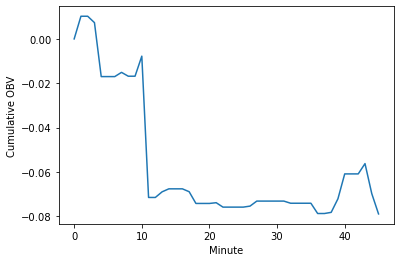

In [287]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
events[(events['match_id'] == 3856030) &
       (events['minute']<45) &
       (events['player.id']==15570)].groupby('minute')['obv_total_net'].fillna(0).cumsum().set_axis(
    np.arange(46)).plot(xlabel = 'Minute', ylabel = 'Cumulative OBV',
                       ax=ax)

<AxesSubplot:xlabel='minute'>

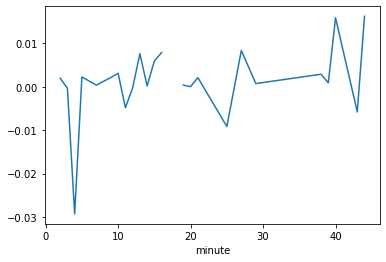

In [77]:
events[(events['match_id'] == 3856030) &
                        (events['minute']<45) &
                        (events['player.id']==10252)
                       ].groupby('minute')['obv_total_net'].mean().plot()